This notebook explains how to use the global_plot_embedding_histogram and global_explain_embedding_components functions for a global explanation of your trained XSWEM model. As a pre-requisite to this notebook we would recommend reading section 4.1.1 of [Baseline Needs More Love: On Simple Word-Embedding-Based Models and Associated Pooling Mechanisms](https://arxiv.org/pdf/1805.09843.pdf), as this is where this method of explanation was originally proposed.

You can run this notebook in Google Colab by right-clicking on the badge below, and opening the link in a new tab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/KieranLitschel/XSWEM/blob/main/notebooks/global_explain_embedding_components.ipynb)

Install XSWEM and [Hugging Face datasets](https://github.com/huggingface/datasets).

In [ ]:
!pip install xswem
!pip install datasets

First we load and prepare the dataset, and train the model. This is very similar code as in the train_xswem notebook, except we modify it for the [yelp_polarity dataset](https://huggingface.co/datasets/viewer/?dataset=yelp_polarity).

From our experience using this method of global explainability, it seems to be important to use pre-trained GloVe embeddings and adapt the frozen embeddings. If we don't use them the model still performs similarly, but it is hard to see a pattern in the maximum values for each dimension.

In [ ]:
## Download the GloVe embeddings. This is the "Common Crawl (42B tokens, 1.9M 
## vocab, uncased, 300d vectors, 1.75 GB download)" dataset, which you can 
## download here https://github.com/stanfordnlp/GloVe. We are hosting a copy
## on Google Drive as downloading from the internet on Google Colab is slow.

import os
if not os.path.isfile("glove.42B.300d.txt"):
    !gdown --id 1LTAMRtx7VYKDI-7r6aG-t3E1nTHx7sG8
    !unzip glove.42B.300d.zip

## Make this notebook deterministic.

RANDOM_SEED = 0

# Python RNG
import random
random.seed(RANDOM_SEED)

# Numpy RNG
import numpy as np
np.random.seed(RANDOM_SEED)

# TF RNG
import tensorflow as tf
from tensorflow.python.framework import random_seed
random_seed.set_seed(RANDOM_SEED)

## Import the necessary modules.

from xswem.model import XSWEM
from xswem.utils import prepare_embedding_weights_map_from_glove
from datasets import load_dataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.data import Dataset
import pandas as pd

## Load and shuffle the dataset. We keep 10% of the training set for validation.

yelp_polarity = load_dataset('yelp_polarity')
yelp_polarity = yelp_polarity.map(lambda row: {
    "text": row["text"].replace("\\n","\n").replace("\\t","\t"), 
    "label": row["label"]})
yelp_polarity = yelp_polarity.shuffle({"train":RANDOM_SEED,"test":RANDOM_SEED})
yelp_polarity["train"] = yelp_polarity["train"].train_test_split(test_size=0.1,seed=RANDOM_SEED)
yelp_polarity_train, yelp_polarity_valid = yelp_polarity["train"]["train"], yelp_polarity["train"]["test"]
X, y = yelp_polarity_train["text"], yelp_polarity_train["label"]
X_valid, y_valid = yelp_polarity_valid["text"], yelp_polarity_valid["label"]
yelp_polarity_test = yelp_polarity["test"]
X_test, y_test = yelp_polarity_test["text"], yelp_polarity_test["label"]



## Build the tokenizer.

NUM_WORDS = 20000 # this means we only keep words where there are at least 50 examples
FILTERS = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n0123456789'
# Its important to set the oov_token to "<unk>"" to match GloVe.
tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token="<unk>", filters=FILTERS)
tokenizer.fit_on_texts(X)
vocab_map = {i+1: tokenizer.index_word[i+1] for i in range(NUM_WORDS)}
# this output map may seem slightly counterintuitive at first, as in the 
# yelp_polarity dataset, the label 0 means a text has negative polarity, and
# 1 means positive polarity. But for our model we're using a sigmoid activation
# function for the output layer as this is a binary classification problem, so 
# we only have only have one unit in the output layer, with an output of 0 
# meaning negative polarity, and 1 meaning positive polarity. So our single 
# output unit identifies if a text has positive polarity, and is labelled as 
# such.
output_map = {
                0: "Positive"
            }

## Prepare the GloVe embeddings.

vocab = vocab_map.values()
embedding_weights_map = prepare_embedding_weights_map_from_glove("glove.42B.300d.txt", vocab, verbose=1)

## Build the dataset pipeline.

BATCH_SIZE = 32
NUM_LABELS = len(output_map)

train_dataset = Dataset.from_tensor_slices((X,y))
valid_dataset = Dataset.from_tensor_slices((X_valid,y_valid))
test_dataset = Dataset.from_tensor_slices((X_test,y_test))

# Repeat and shuffle the train datasets.
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.shuffle(BATCH_SIZE*2)

# Tokenize the text.
# We only keep unique tokens as XSWEM is invariant to token frequency and order.
tokenize = lambda text, label: (tf.py_function(lambda text: np.unique(tokenizer.texts_to_sequences([str(text.numpy())])[0]), inp=[text], Tout=tf.int32), label)
train_dataset = train_dataset.map(tokenize,num_parallel_calls=tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.map(tokenize,num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(tokenize,num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Pre-fetch so that GPU spends less time waiting.
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Padded batch allows us to handle varying sentence lengths.
train_dataset = train_dataset.padded_batch(BATCH_SIZE,padded_shapes=([None],[]))
valid_dataset = valid_dataset.padded_batch(BATCH_SIZE,padded_shapes=([None],[]))
test_dataset = test_dataset.padded_batch(BATCH_SIZE,padded_shapes=([None],[]))

## Build the XSWEM model.
model = XSWEM(300, "sigmoid", vocab_map, output_map, mask_zero=True, embedding_weights_map=embedding_weights_map, adapt_embeddings=True, freeze_embeddings=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)
model.compile(optimizer, loss="binary_crossentropy", metrics="accuracy")

## Train XSWEM model.
model.fit(train_dataset, validation_data=valid_dataset, epochs=20, steps_per_epoch=10000, callbacks=[tf.keras.callbacks.EarlyStopping('val_accuracy', restore_best_weights=True)], verbose=2)

## Test XSWEM model.
model.evaluate(test_dataset)

Reusing dataset yelp_polarity (/root/.cache/huggingface/datasets/yelp_polarity/plain_text/1.0.0/2b33212d89209ed1ea0522001bccc5f5a5c920dd9c326f3c828e67a22c51a98c)
Loading cached processed dataset at /root/.cache/huggingface/datasets/yelp_polarity/plain_text/1.0.0/2b33212d89209ed1ea0522001bccc5f5a5c920dd9c326f3c828e67a22c51a98c/cache-39795918bc77a6d3.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/yelp_polarity/plain_text/1.0.0/2b33212d89209ed1ea0522001bccc5f5a5c920dd9c326f3c828e67a22c51a98c/cache-c503b806bebe9346.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/yelp_polarity/plain_text/1.0.0/2b33212d89209ed1ea0522001bccc5f5a5c920dd9c326f3c828e67a22c51a98c/cache-86287e45fb253470.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/yelp_polarity/plain_text/1.0.0/2b33212d89209ed1ea0522001bccc5f5a5c920dd9c326f3c828e67a22c51a98c/cache-771e79be57aea394.arrow
Loading cached split indices for dat

Epoch 1/20
10000/10000 - 203s - loss: 0.3883 - accuracy: 0.8225 - val_loss: 0.2892 - val_accuracy: 0.8777
Epoch 2/20
10000/10000 - 199s - loss: 0.2654 - accuracy: 0.8880 - val_loss: 0.2496 - val_accuracy: 0.8963
Epoch 3/20
10000/10000 - 199s - loss: 0.2338 - accuracy: 0.9028 - val_loss: 0.2266 - val_accuracy: 0.9062
Epoch 4/20
10000/10000 - 200s - loss: 0.2196 - accuracy: 0.9098 - val_loss: 0.2155 - val_accuracy: 0.9112
Epoch 5/20
10000/10000 - 199s - loss: 0.2111 - accuracy: 0.9138 - val_loss: 0.2301 - val_accuracy: 0.9032
1188/1188 [==============================] - 22s 18ms/step - loss: 0.2106 - accuracy: 0.9131


[0.21059906482696533, 0.9131052494049072]

We plot a histogram of the component values, and observe that our model has learnt sparse embeddings, with most values centred around 0 and some very large values. This is the same pattern as observed in figure 1 of the [original paper](https://arxiv.org/pdf/1805.09843.pdf).

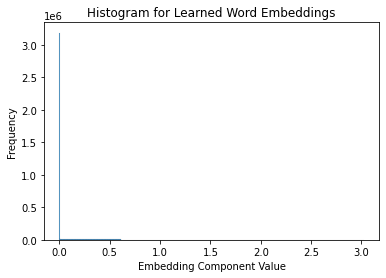

In [ ]:
model.global_plot_embedding_histogram(adapt_embeddings=True)

Below we show the results of our explainabiity function. This determines the top five words with the largest values for each component of the embeddings, and is equivalent to table 3 in the original paper. We label the columns of the table with the index of the component in the embedding vector.

A lot of the components appear to be quite noisy, with no clear relevance to the classification task. We show the first 10 components here to demonstrate this.

In [ ]:
global_explained_embedding_components = model.global_explain_embedding_components(adapt_embeddings=True)
global_explained_embedding_components.iloc[:, :10]

,0,1,2,3,4,5,6,7,8,9
Word Rank,,,,,,,,,,
1,quel,chicken,sip,pouvez,bulb,steam,seit,directv,nuong,countertop
2,panko,latex,fresh,tacos,bible,plates,whey,mbps,android,dispenser
3,sa,daal,grub,albacore,ce,cake,cholesterol,dish,ipad,counter
4,sore,masks,smoothie,michelada,parts,birthday,shiitake,imax,markup,gender
5,offensive,flags,sorbet,chaque,puzzle,bikes,poultry,pedicure,kindle,optical


There are some components though which really seem to be capturing a much clearer polarity, but note there is often still some noise. For example the components below.

In [ ]:
clear_polarity = [37, 60, 159]
global_explained_embedding_components.iloc[:, clear_polarity]

,37,60,159
Word Rank,,,
1,negligent,vampires,took
2,resigned,rudest,hated
3,wanton,pitchers,teased
4,unoccupied,dirtiest,ended
5,lethargic,nastiest,offensive
